# 微信信贷反欺诈数据分析

## 1. 总体情况

### 1. 找到与未找到的记录分布

黑名单1000个，白名单1000个，共计2000个。

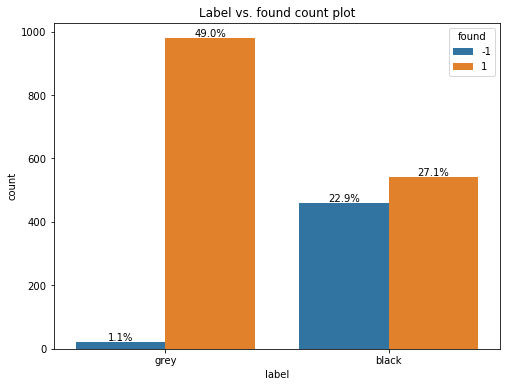

In [3]:
import os
import re
import warnings

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")

data_dir = 'data/wechat'
fig_dir = 'image/wechat'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)


def only_number(x):
    try:
        pattern = re.compile('-*\d+')
        y = x[pattern.search(x).start():]
        return int(y)
    except:
        return np.nan


grey_df = pd.read_excel('{}/wechat.xlsx'.format(data_dir), sheetname='Sheet1')
black_df = pd.read_excel('{}/wechat.xlsx'.format(data_dir), sheetname='Sheet2')

grey_df.rename(columns={
    'found:1': 'found',
    'risk_score:87': 'risk_score',
    'risk_code:5': 'risk_code_1',
    'risk_value:2': 'risk_value_1',
    'risk_code:8': 'risk_code_2',
    'risk_value:3': 'risk_value_2',
    'Unnamed: 8': 'risk_code_3',
    'Unnamed: 9': 'risk_value_3',
    'Unnamed: 10': 'risk_code_4',
    'Unnamed: 11': 'risk_value_4',
    'Unnamed: 12': 'risk_code_5',
    'Unnamed: 13': 'risk_value_5',
    }, inplace=True)
del grey_df['id_found:-1']
grey_df['id'] = grey_df['id'].astype(object)
for column in grey_df.columns[1:]:
    grey_df[column] = grey_df[column].apply(lambda x: only_number(x))
grey_df['label'] = 'grey'

black_df.rename(columns={
    'pname_id': 'id',
    'found:-1': 'found',
    'risk_score:99': 'risk_score',
    'Unnamed: 5': 'risk_code_1',
    'Unnamed: 6': 'risk_value_1',
    'Unnamed: 7': 'risk_code_2',
    'Unnamed: 8': 'risk_value_2',
    'Unnamed: 9': 'risk_code_3',
    'Unnamed: 10': 'risk_value_3'
    }, inplace=True)
del black_df['id_found:-1']
del black_df['pname']

black_df['id'] = black_df['id'].astype(object)
for column in black_df.columns[1:]:
    black_df[column] = black_df[column].apply(lambda x: only_number(x))
black_df['label'] = 'black'

id_df = grey_df.append(black_df)

risk_code_dict = {
    1: '信贷中介',
    2: '不法分子',
    3: '虚假资料',
    4: '羊毛党',
    5: '身份认证失败',
    6: '疑似恶意欺诈',
    7: '失信名单',
    8: '异常支付行为',
    301: '恶意环境',
    503: '其他异常行为'
    }

risk_value_dict = {
    1: '低风险',
    2: '中风险',
    3: '高风险'
    }


def label_found_countplot(id_df):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    sns.countplot(id_df['label'], hue=id_df['found'])
    for bar in ax.patches:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height, '%.1f' % (height * 100 / 2000) + "%", ha='center',
                va='bottom')
    ax.set_title('Label vs. found count plot')
#     fig.savefig('{}/label_found_countplot.jpg'.format(fig_dir))
    plt.show()

label_found_countplot(id_df)

其中绝大多数灰名单中绝大多数记录均能被找到，占2000条的49%。而黑名单中仅有超过一半的记录能被找到，占2000条的27.1%。能找到的记录共计1520条。

### 2. 欺诈分值分布

在这能被找到的1520条记录中，欺诈分值在灰名单和黑名单的分布如下图所示。其中黑名单的分布大致呈现一个单峰，平均值在62分左右，其中在40分处有一个小峰。而灰名单的分布则呈现更明显的双峰，主峰位置在58分左右，低于黑名单主峰，而次峰位于95分处的高峰值。可以看到就主峰情况而言，黑名单的欺诈分值高于灰名单，但是就次峰而言，灰名单的欺诈分值却极高，与之相对应的，黑名单的欺诈分值却极低。

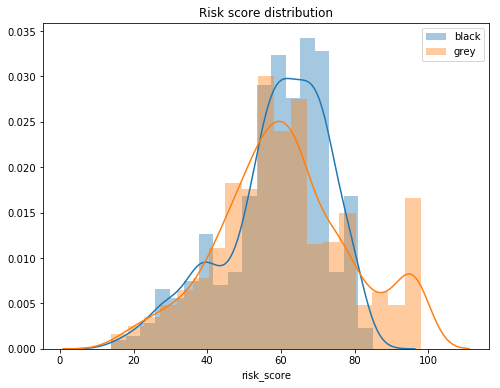

In [4]:
def define_id_df_sub(id_df):
    id_df_sub = id_df[id_df['found'] == 1]
    id_df_sub['risk_code_num'] = 1 + (id_df_sub['risk_code_1'] > 0) + (id_df_sub['risk_code_2'] > 0) + (
        id_df_sub['risk_code_3'] > 0) + (id_df_sub['risk_code_4'] > 0) + (id_df_sub['risk_code_5'] > 0) - 1
    id_df_sub['risk_value_sum'] = np.nansum(
        id_df_sub[['risk_value_1', 'risk_value_2', 'risk_value_3', 'risk_value_4', 'risk_value_5']], axis=1)
    return id_df_sub

def risk_score_distplot(id_df_sub):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    if len(id_df_sub.loc[id_df_sub['label'] == 'black']) > 0:
        sns.distplot(id_df_sub.loc[id_df_sub['label'] == 'black', 'risk_score'], label='black')
    if len(id_df_sub.loc[id_df_sub['label'] == 'grey']) > 0:
        sns.distplot(id_df_sub.loc[id_df_sub['label'] == 'grey', 'risk_score'], label='grey')
    plt.legend(loc='best')
    plt.title('Risk score distribution')
#     plt.savefig('{}/risk score distribution.jpg'.format(fig_dir))
    plt.show()

id_df_sub = define_id_df_sub(id_df)
risk_score_distplot(id_df_sub)

### 3. 同一ID触发风险码数量分布

其中每一个ID可以触发零条或者更多条的风险。根据每个ID触发的风险数量不同做出下图。可以看到，整体而言，触发风险在0条~3条。其中灰名单ID中最高触发至5条风险。触发0条风险的ID中，黑名单占比相对于触发多条风险的黑名单占比而言更多。黑名单ID随着触发条数增加而ID数量减少。而灰名单ID则在触发1条风险处最高，其次是0条，再其次是2至多条递减。这图从侧面印证上图次峰位置异常，黑名单在风险触发0条处较多，而灰名单长尾，在触发风险4条和5条均有分布。

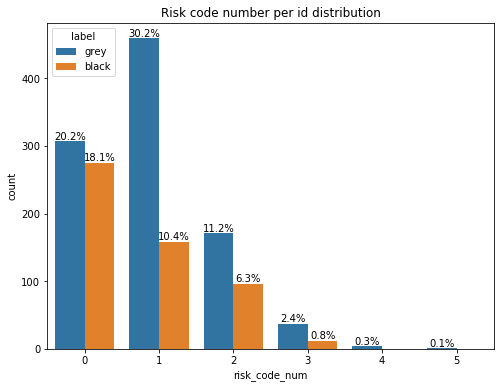

In [5]:
def risk_code_number_per_id_countplot(id_df_sub):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    sns.countplot(id_df_sub['risk_code_num'], hue=id_df_sub['label'])
    for bar in ax.patches:
        if bar.get_height() > 0:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height, '%.1f' % (height * 100 / 1520) + "%", ha='center',
                    va='bottom')
    plt.title('Risk code number per id distribution')
#     plt.savefig('{}/risk code number per id distribution.jpg'.format(fig_dir))
    plt.show()
    
risk_code_number_per_id_countplot(id_df_sub)

### 4. 同一ID触发风险值总和分布

同理可以做出每一个ID在所有触发的风险中的风险值总和分布。情况与上图类似，唯一值得说明的是，在风险总值为1和为6和为8的三个情况下，黑名单的数量高于灰名单，其余情况，均为灰名单高于黑名单。

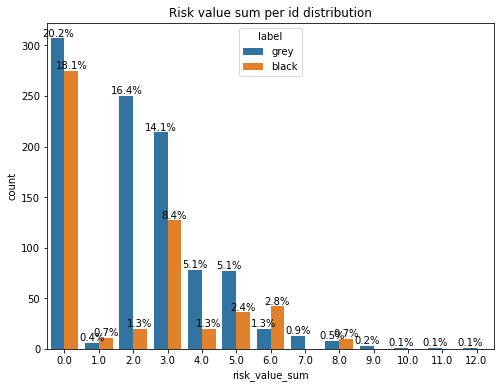

In [6]:
def risk_value_sum_per_id_countplot(id_df_sub):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    sns.countplot(id_df_sub['risk_value_sum'], hue=id_df_sub['label'])
    for bar in ax.patches:
        if bar.get_height() > 0:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height, '%.1f' % (height * 100 / 1520) + "%", ha='center',
                    va='bottom')
    plt.title('Risk value sum per id distribution')
#     plt.savefig('{}/risk value sum per id distribution.jpg'.format(fig_dir))
    plt.show()

risk_value_sum_per_id_countplot(id_df_sub)

### 5. 不同风险码分布

下面是风险码在数据中的分布情况，灰名单触发的风险码多样，而黑名单触发的风险码仅有三个，分别是身份认证失败，异常支付行为和失信名单。且按相对比例而言，在失信名单这类风险中，黑名单占据绝大多数。而灰名单主要触发的风险为异常支付行为，身份认证失败这两类。

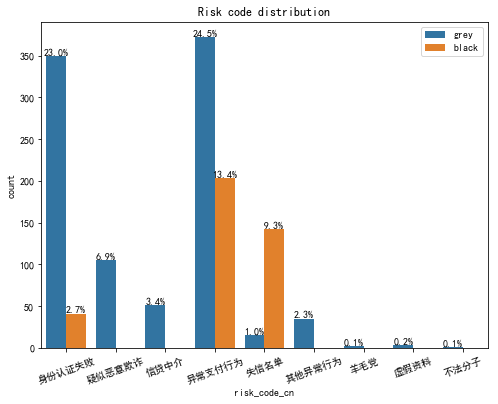

In [7]:
def define_risk_df(id_df_sub):
    risk_code_list = []
    risk_value_list = []
    label_list = []
    id_list = []
    n = 0
    for i, row in id_df_sub.iterrows():
        for risk_code_column, risk_value_column in zip(
                ['risk_code_1', 'risk_code_2', 'risk_code_3', 'risk_code_4', 'risk_code_5'],
                ['risk_value_1', 'risk_value_2', 'risk_value_3', 'risk_value_4', 'risk_value_5']):
            if row[risk_code_column] > 0:
                risk_code_list.append(row[risk_code_column])
                risk_value_list.append(row[risk_value_column])
                label_list.append(row['label'])
                id_list.append(n)
                n = n + 1
    risk_df = pd.DataFrame({
        'id': id_list,
        'label': label_list,
        'risk_code': risk_code_list,
        'risk_value': risk_value_list
        })

    risk_df['risk_code_cn'] = risk_df['risk_code'].map(risk_code_dict)
    risk_df['risk_value_cn'] = risk_df['risk_value'].map(risk_value_dict)
    return risk_df


def risk_code_countplot(risk_df):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    sns.countplot(risk_df['risk_code_cn'], hue=risk_df['label'])
    for bar in ax.patches:
        if bar.get_height() > 0:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height, '%.1f' % (height * 100 / 1520) + "%", ha='center',
                    va='bottom')
    plt.title('Risk code distribution')
    plt.legend(loc='upper right')
    plt.xticks(rotation=20)
#     plt.savefig('{}/risk code distribution.jpg'.format(fig_dir))
    plt.show()

risk_df = define_risk_df(id_df_sub)
risk_code_countplot(risk_df)

### 6. 同一风险码的风险值分布

下面对每一种风险码，讨论其黑灰名单的分布，以及不同风险值的分布。

不法分子这类风险仅有灰名单触发，且触发的均为低风险值。

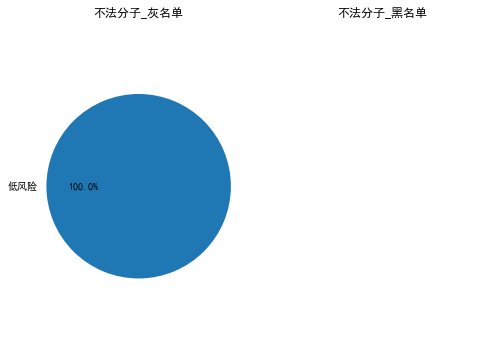

In [8]:
def risk_value_pieplot(risk_df, risk_code):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(121)
    # plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.pie(risk_df.loc[(risk_df['risk_code_cn'] == risk_code) & (
            risk_df['label'] == 'grey'), 'risk_value_cn'].value_counts().values, labels=risk_df.loc[
        (risk_df['risk_code_cn'] == risk_code) & (
                risk_df['label'] == 'grey'), 'risk_value_cn'].value_counts().index, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title('{}_灰名单'.format(risk_code))

    ax1 = fig.add_subplot(122)
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.pie(risk_df.loc[(risk_df['risk_code_cn'] == risk_code) & (
            risk_df['label'] == 'black'), 'risk_value_cn'].value_counts().values, labels=risk_df.loc[
        (risk_df['risk_code_cn'] == risk_code) & (
                risk_df['label'] == 'black'), 'risk_value_cn'].value_counts().index, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title('{}_黑名单'.format(risk_code))
#     plt.savefig('{}/risk code {} value pie.jpg'.format(fig_dir, risk_code))
    plt.show()
        
risk_value_pieplot(risk_df, '不法分子')

信贷中介这类风险仅有灰名单触发，且有21.6%为高风险值，其余为中风险值。

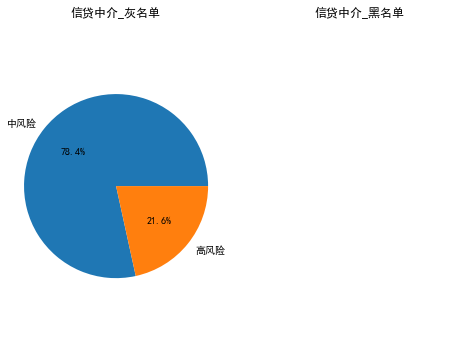

In [9]:
risk_value_pieplot(risk_df, '信贷中介')

其他异常行为风险仅有灰名单触发，其中低风险值过半为60%，中风险值为31.4%，高风险值为8.6%

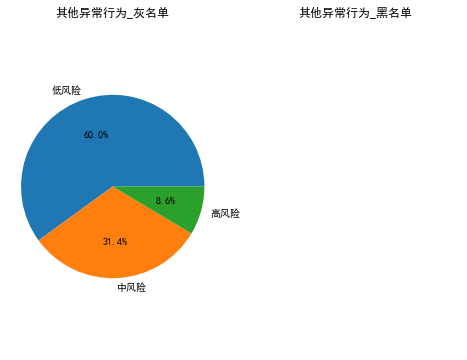

In [10]:
risk_value_pieplot(risk_df, '其他异常行为')

失信名单风险灰名单和黑名单均有触发，且触发的均为高风险值。

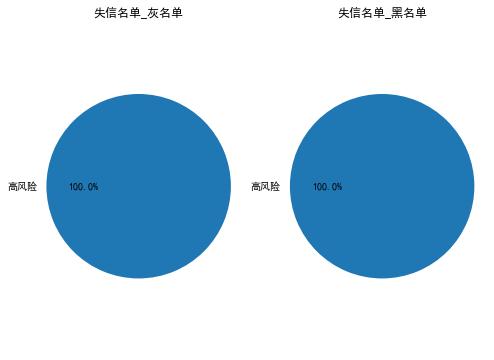

In [11]:
risk_value_pieplot(risk_df, '失信名单')

异常支付行为风险灰名单和黑名单均有触发，灰名单中高风险比例高于黑名单。而黑名单的中低风险比例高于灰名单。

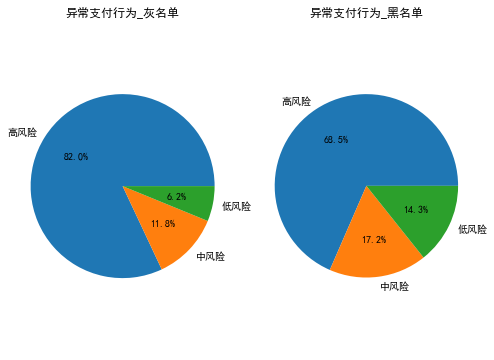

In [12]:
risk_value_pieplot(risk_df, '异常支付行为')

疑似恶意欺诈风险中仅有灰名单触发，高风险值占据21%，其余79%为中风险。

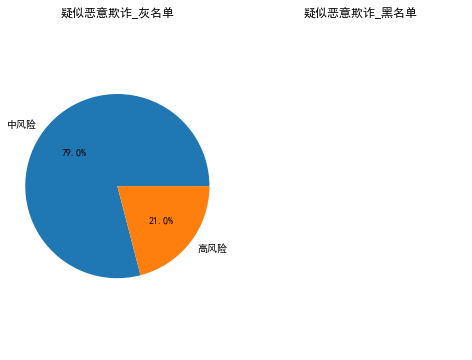

In [13]:
risk_value_pieplot(risk_df, '疑似恶意欺诈')

羊毛党风险仅有灰名单触发，均为中风险。

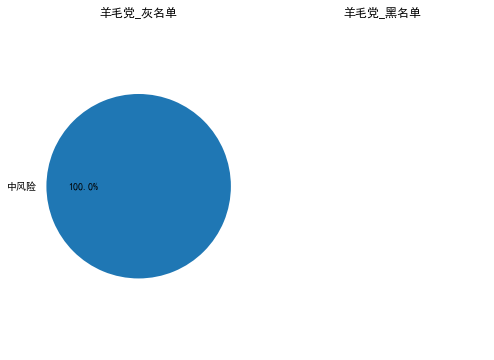

In [14]:
risk_value_pieplot(risk_df, '羊毛党')

虚假资料风险仅有灰名单触发，均为高风险。

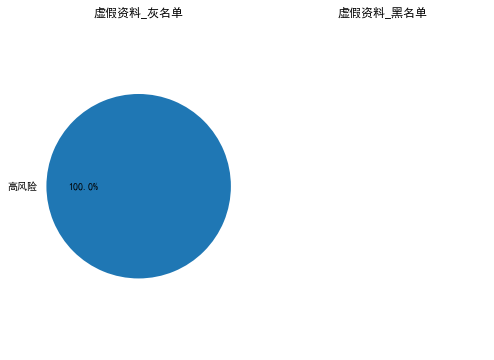

In [15]:
risk_value_pieplot(risk_df, '虚假资料')

身份认证失败黑名单和灰名单均有触发，触发均为中风险。

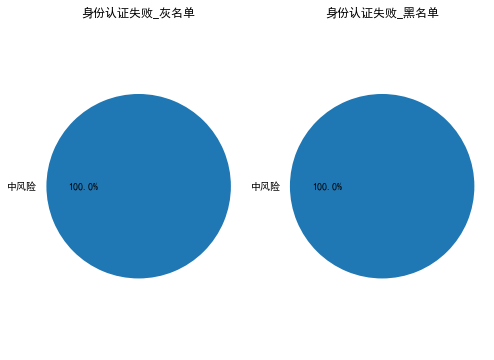

In [16]:
risk_value_pieplot(risk_df, '身份认证失败')

## 2. 分段讨论

下面根据欺诈分值分布分为三段分别进行分析，第一段是0~45分，这个区间有黑名单的次峰。第二段是45分~85分，这个区间有黑名单和灰名单的主峰。第三段为85分~100分，这个区间有灰名单的次峰。

### 1. 0~45分段

在欺诈分值为0~45分段，可以看到黑名单没有触发任何风险，所以分值较低，而灰名单有总量1.2%的ID触发了一条风险码，该风险码为身份认证失败，风险值为中风险。

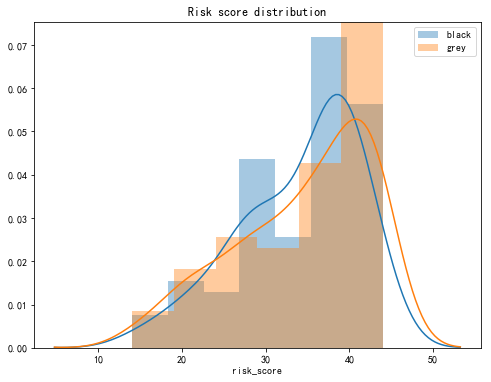

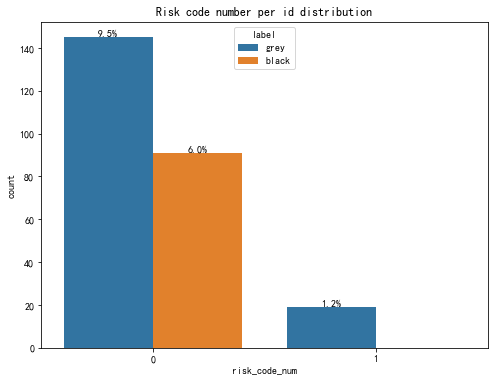

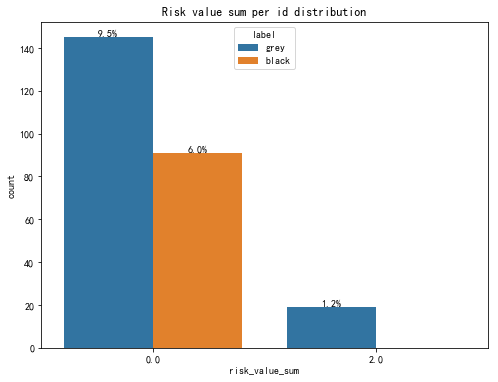

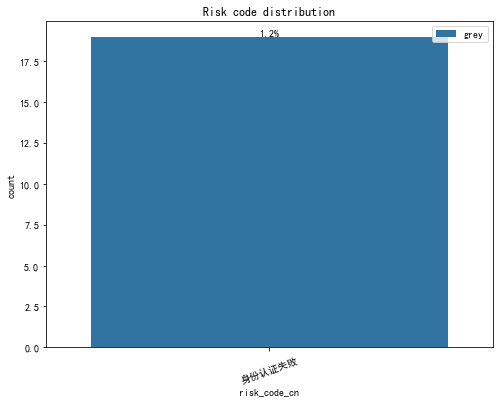

In [17]:
id_df_sub = define_id_df_sub(id_df)
id_df_sub = id_df_sub[id_df_sub['risk_score']<45]
risk_score_distplot(id_df_sub)
risk_code_number_per_id_countplot(id_df_sub)
risk_value_sum_per_id_countplot(id_df_sub)
risk_df = define_risk_df(id_df_sub)
risk_code_countplot(risk_df)

### 2. 85~100分段

在欺诈分值85分至100分区间，没有黑名单记录， 仅有灰名单记录。触发的风险码也多样，最多的是异常支付行为，其次是疑似恶意期债，其他异常行为，信贷中介，身份认证失败，失信名单和羊毛党。而多条风险出现在一个ID的情况也常见，所有ID均有触发一条及以上的风险，触发的风险值总和也从2至12不同，大多集中在3~5风险值和1~2条风险码。

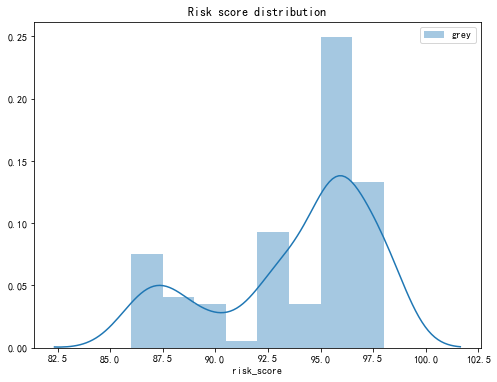

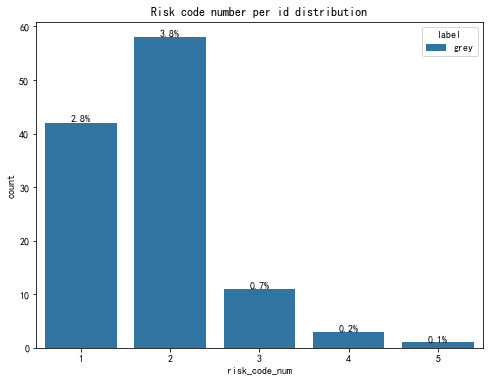

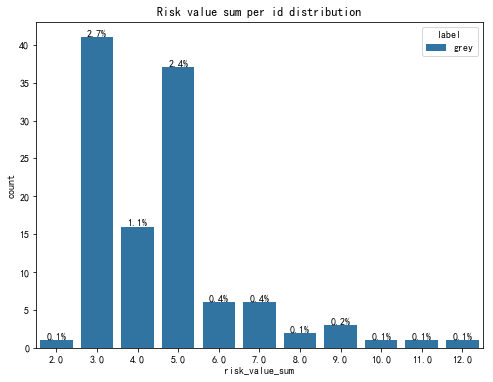

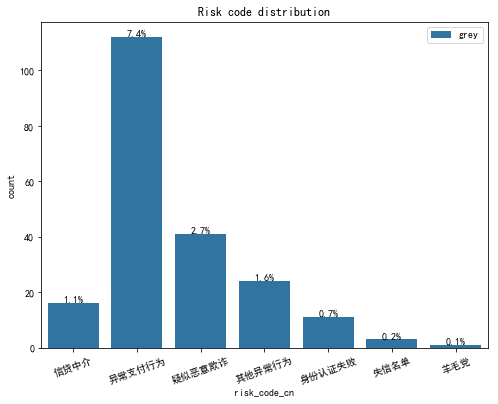

In [18]:
id_df_sub = define_id_df_sub(id_df)
id_df_sub = id_df_sub[id_df_sub['risk_score']>85]
risk_score_distplot(id_df_sub)
risk_code_number_per_id_countplot(id_df_sub)
risk_value_sum_per_id_countplot(id_df_sub)
risk_df = define_risk_df(id_df_sub)
risk_code_countplot(risk_df)

### 3. 45~85分段

在欺诈峰值45分至85分区间，为黑名单和灰名单的主峰区间。黑名单主峰位置略高于灰名单。在这个区间每个ID触发风险条数为0~4条，大多为1条。虽然触发条数，黑名单在高触发条数的范围内比例低，但是就风险值总和分布而言，黑名单的风险值总和在高分范围内比例却明显多于灰名单，这就造成了黑名单的主峰欺诈分值更高，即黑名单触发的风险条数虽少，但风险值却高。而这样的高风险值的风险码就是失信名单。

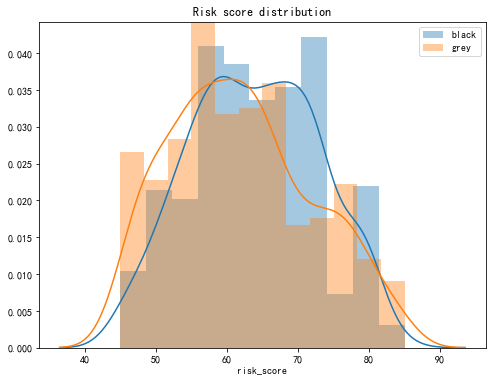

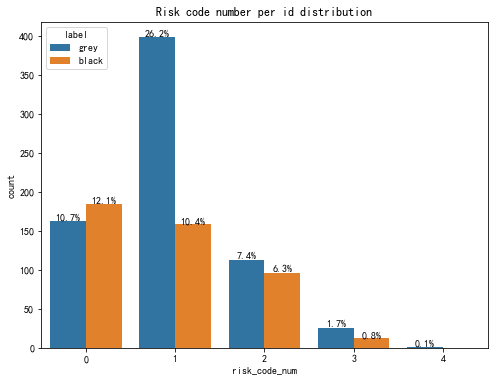

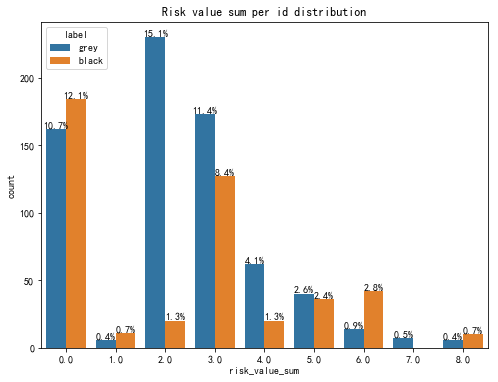

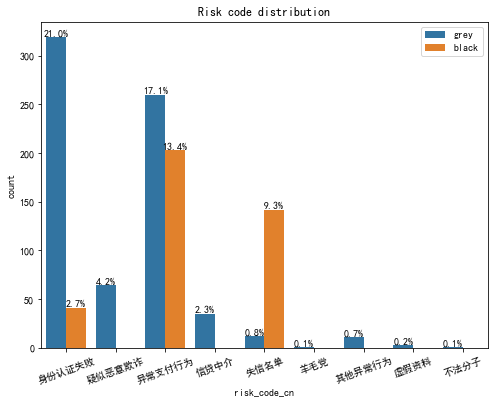

In [19]:
id_df_sub = define_id_df_sub(id_df)
id_df_sub = id_df_sub[(id_df_sub['risk_score']<=85)&(id_df_sub['risk_score']>=45)]
risk_score_distplot(id_df_sub)
risk_code_number_per_id_countplot(id_df_sub)
risk_value_sum_per_id_countplot(id_df_sub)
risk_df = define_risk_df(id_df_sub)
risk_code_countplot(risk_df)

## 3. 总结

总体而言，在灰名单的欺诈分值应该低于黑名单的前提下，可以看到，通过微信信贷反欺诈功能进行正确区分需要严重依赖于微信的失信名单。如果微信的失信名单全而准，那么能更好地将黑名单的欺诈分数提上去。其次可以看到，灰名单触发的风险码更多样，但是这也造成了一定程度的误判，在欺诈分数低的区间，由于黑名单不会触发到风险码，而灰名单会触发到身份认证失败的风险码，造成灰名单在低分段分布较高，建议完善身份认证失败这个风险码，可能是一个身份证或者姓名对应多个手机号，使得灰名单的正常ID不会触发到该风险码。在高分数段，黑名单无分布，而灰名单有分布。触发的风险码最多的异常支付行为，建议降低该风险码的风险程度或者是敏感程度。

最后需要强调的是由于黑名单有几乎一半的记录无法被找到，这造成此次数据分析结果可能有偏。如果这是正常的，那么说明有近一半的潜在黑名单甚至无法通过微信的信贷反欺诈做出评分。